In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn
seaborn.set_style("white")
seaborn.set_context("paper")

from hips.plotting.layout import create_axis_at_location

plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_nichols_data, load_kato_data
import zimmer.plotting as zplt
from zimmer.util import cached

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [33]:
# Specify hyperparameters
results_dir = "results/combined/2018-10-08/"
figures_dir = os.path.join(results_dir, "figures")

In [35]:
# Load the data
groups = ["n2_1_prelet", 
          "n2_2_let",
          "npr1_1_prelet",
          "npr1_2_let"]

worms_and_groups = [(i, "n2_1_prelet") for i in range(11)] + \
                   [(i, "n2_2_let") for i in range(12)] + \
                   [(i, "npr1_1_prelet") for i in range(10)] + \
                   [(i, "npr1_2_let") for i in range(11)]
worm_names = ["{} worm {}".format(group, i) for (i, group) in worms_and_groups]

ys_nichols, ms_nichols, us_nichols, z_trues_nichols, z_true_key_nichols, neuron_names_nichols = \
    load_nichols_data(worms_and_groups, worm_names, include_unnamed=False, signal="dff")

Only including named neurons.
73 neurons across all 44 worms


In [36]:
ys_kato, ms_kato, z_trues_kato, z_true_key_kato, neuron_names_kato = \
    load_kato_data(include_unnamed=False, signal="dff")
    
# Kato recorded at 21% oxygen concentration
us_kato = [21 * np.ones(y.shape[0]) for y in ys_kato]

Only including named neurons.
59 neurons across all 5 worms


# Combine the two datasets

In [37]:
neuron_names = np.unique(np.concatenate((neuron_names_nichols, neuron_names_kato)))
names_to_inds = dict([(name, ind) for ind, name in enumerate(neuron_names)])
N = len(neuron_names)

In [38]:
z_true_key = dict(Rev=0,
                  Fwd=1,
                  VT=2,
                  DT=3,
                  Q=4,
                  Other=5)

z_map_kato=dict(REVSUS="Rev",
                SLOW="Fwd",
                FWD="Fwd",
                VT="VT",
                DT="DT",
                REV2="Rev",
                REV1="Rev",
                NOSTATE="Other")

z_map_nichols=dict([("Quiescence", "Q"),
                    ("Forward", "Fwd"),
                    ("Reversal", "Rev"),
                    ("Ventral turn", "VT"),
                    ("Dorsal turn", "DT"),
                    ("undefined turn", "Other")])

In [39]:
ys = []
ms = []
us = []
z_trues = []
papers = []

kato_inds = np.array([names_to_inds[name] for name in neuron_names_kato], dtype=int)
for y, m, u, z in zip(ys_kato, ms_kato, us_kato, z_trues_kato):
    T = y.shape[0]
    yy = np.zeros((T, N))
    yy[:, kato_inds] = y    
    mm = np.zeros((T, N), dtype=bool)
    mm[:, kato_inds] = m
    
    ys.append(yy)
    ms.append(mm)
    us.append(u)
    
    znew = -1 * np.ones(T, dtype=int)
    for k, name in enumerate(z_true_key_kato):
        newname = z_map_kato[name]
        znew[z == k] = z_true_key[newname]
    assert np.all(znew >= 0)
    z_trues.append(znew)
    papers.append("kato")
    
# Append Nichols data
nichols_inds = np.array([names_to_inds[name] for name in neuron_names_nichols], dtype=int)
for y, m, u, z in zip(ys_nichols, ms_nichols, us_nichols, z_trues_nichols):
    T = y.shape[0]
    yy = np.zeros((T, N))
    yy[:, nichols_inds] = y    
    mm = np.zeros((T, N), dtype=bool)
    mm[:, nichols_inds] = m
    
    ys.append(yy)
    ms.append(mm)
    us.append(u)

    znew = -1 * np.ones(T, dtype=int)
    for k, name in enumerate(z_true_key_nichols):
        newname = z_map_nichols[name]
        znew[z == k] = z_true_key[newname]
    z_trues.append(znew)
    assert np.all(znew >= 0)

    papers.append("nichols")

In [40]:
with open(os.path.join(results_dir, "z_trues.pkl"), "wb") as f:
    pickle.dump((z_trues, z_true_key, z_map_kato, z_map_nichols), f)
    

In [41]:
with open(os.path.join(results_dir, "us.pkl"), "wb") as f:
    pickle.dump(us, f)

In [44]:
ys = [trend_filter(y, npoly=1, nexp=4) for y in ys]
# ys = [standardize(y, m) for y, m in zip(ys, ms)]
# K_true = len(z_true_key)
K_true = 8
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

# Empirical correlation

In [48]:
def compute_correlation():
    C = np.nan * np.ones((N, N))
    
    for i in range(N):
        for j in range(N):
            Ei, Ej, Eii, Ejj, Eij = 0, 0, 0, 0, 0
            n = 0
            for y, m in zip(ys, ms):
                if not np.any(m[:,i] & m[:, j]):
                    continue
                inds = m[:, i] & m[:, j]
                Ei += np.sum(y[inds, i])
                Ej += np.sum(y[inds, j])
                Eii += np.sum(y[inds, i] * y[inds, i])
                Ejj += np.sum(y[inds, j] * y[inds, j])
                Eij += np.sum(y[inds, i] * y[inds, j])
                n += np.sum(inds.astype(int))
            
            if n > 0:
                Ei /= n
                Ej /= n
                Eii /= n
                Ejj /= n
                Eij /= n
                C[i, j] = (Eij - Ei * Ej) / np.sqrt(Eii - Ei**2) / np.sqrt(Ejj - Ej**2)
    
    return C

_corr = cached(results_dir, "corr")(compute_correlation)
emp_corr = _corr()
                

# PCA 

In [51]:
# Run PCA to get a 3d projection of the data
from ssm.preprocessing import pca_with_imputation
_pca = cached(results_dir, "pca_D{}".format(20))(pca_with_imputation)
pca, x_fulls = _pca(20, ys, ms, num_iters=100)

(1, 21)

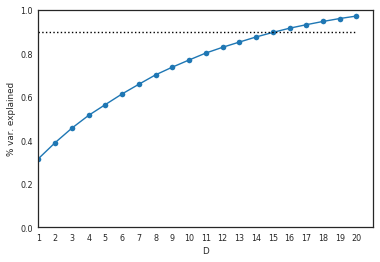

In [79]:
# Determine number of PCs to use
plt.plot(np.arange(1, 21), np.cumsum(pca.explained_variance_ratio_), '-o')
plt.plot(np.arange(1, 21), 0.9 * np.ones(20), ':k')
plt.xlabel("D")
plt.ylabel("% var. explained")
plt.ylim(0,1)
plt.xticks(np.arange(21))
plt.xlim(1, 21)

In [53]:
D = 15
xs = [x[:,:D] for x in x_fulls]

In [55]:
# To compute the correlation under the PCA model, we need the covariance of the PCA embeddings
C_pca = pca.components_.T[:, :D]
L_x = np.linalg.cholesky(np.cov(np.vstack(xs).T))
C_pca = C_pca.dot(L_x)
Cn_pca = C_pca / np.linalg.norm(C_pca, ord=2, axis=1, keepdims=True)
pca_corr = Cn_pca.dot(Cn_pca.T)

# Factor Analysis

In [58]:
# # Fit a test model
# def fit_factor_analysis(D, num_gibbs_iters=20, num_em_iters=100):
    
#     # Special case D == 0
#     if D == 0:
#         mu = np.zeros(N)
#         Sigma = np.diag(np.nanvar(np.vstack(train_ys), axis=0))
        
#         lp = 0
#         for y, m in zip(train_ys, train_ms):
#             mu_i = mu[m[0]]
#             Sigma_i = Sigma[np.ix_(m[0], m[0])]
#             lp += np.sum(multivariate_normal.logpdf(y[:, m[0]], mu_i, Sigma_i))
        
#         val_ll = 0
#         for y, m in zip(val_ys, val_ms):
#             mu_i = mu[m[0]]
#             Sigma_i = Sigma[np.ix_(m[0], m[0])]
#             val_ll += np.sum(multivariate_normal.logpdf(y[:, m[0]], mu_i, Sigma_i))
        
#         return Sigma, np.array([lp]), val_ll
        
#     # For D > 1, fit a factor analysis model
#     from pybasicbayes.models import FactorAnalysis
#     fa = FactorAnalysis(N, D)
#     for y, m in zip(train_ys, train_ms):
#         fa.add_data(y, mask=m.astype(bool))

#     lps = []
#     for _ in tqdm(range((num_gibbs_iters))):
#         fa.resample_model()
#         lps.append(fa.log_likelihood())

#     for _ in tqdm(range((num_em_iters))):
#         fa.EM_step()
#         lps.append(fa.log_likelihood())

#     # Compute marginal likelihood of validation data
#     mu = np.zeros(N)
#     Sigma = fa.W.dot(fa.W.T) + np.diag(fa.sigmasq)
    
#     val_ll = 0
#     for y, m in zip(val_ys, val_ms):
#         m0 = m[0]
#         mu_i = mu[m0]
#         Sigma_i = Sigma[np.ix_(m0, m0)]
#         vll = multivariate_normal.logpdf(y[:, m0], mu_i, Sigma_i)
#         assert vll.shape == (y.shape[0],)
#         val_ll += np.sum(vll)
    
#     return fa, lps, val_ll

# Ds = [10]
# fas = []
# lpss = []
# val_lls = []
# for D in Ds:
#     print("Fitting FA with D=", D)
#     _fa = cached(results_dir, "fa_D{}".format(D))(fit_factor_analysis)
#     fa, lps, val_ll = _fa(D)
#     fas.append(fa)
#     lpss.append(lps)
#     val_lls.append(val_ll)

In [59]:
# for D, lps in zip(Ds, lpss):
#     plt.plot(lps, label="D={}".format(D))
# #     plt.xlim(21, 120)
# plt.legend()

# plt.figure()
# plt.plot(Ds, val_lls)
# ll_95 = np.min(val_lls[1:]) + 0.95 * (np.max(val_lls) - np.min(val_lls[1:]))
# plt.plot(Ds, ll_95 * np.ones_like(Ds), ':k')
# plt.legend()

In [60]:
# # Find an orthogonal emission matrix from the factor analysis loadings
# C_fa = fa.W
# Sigma = np.dot(C_fa, C_fa.T) + np.diag(fa.sigmasq)
# evals, evecs = np.linalg.eigh(Sigma, )
# inds = np.argsort(evals)[::-1][:D]
# Cstar_fa = evecs[:, inds]

# # Find the linear transformation that maps C to Cstar
# #    Cstar = C \dot R
# #    Cstar R^{-1} = C
# #    y = Cx = Cstar R^{-1} x
# R, _, _, _ = np.linalg.lstsq(C_fa, Cstar_fa)
# Ri = np.linalg.inv(R)

# # Counter rotate the continuous latent states
# xs_fa = [d.Z.dot(Ri.T) for d in fa.data_list]

# # Compute the correlation under the FA model
# Cn_fa = C_fa / np.linalg.norm(C_fa, ord=2, axis=1, keepdims=True)
# fa_corr = Cn_fa.dot(Cn_fa.T)

In [61]:
# plt.plot(xs_fa[28] + np.arange(10))

In [62]:
# for w in range(5, W):
#     yw = ys[w].copy()
#     yw[~ms[w]] = np.nan
#     plt.plot(np.nanmean(yw, axis=1), alpha=.25, c='k')

In [63]:
# w_to_plot = np.concatenate((np.arange(5), 5 + 3 + np.array([0, 11, 23, 33])))
# plt.figure(figsize=(12, 4))
# for i, w in enumerate(w_to_plot): 
#     ax = plt.subplot(2, len(w_to_plot), i+1)
#     zplt.plot_2d_continuous_states(xs_fa[w], z_trues[w], xlims=(-2, 2), ylims=(-2, 2), inds=(0, 1), ax=ax)
#     plt.xticks([])
#     plt.yticks([])
    
#     ax = plt.subplot(2, len(w_to_plot), len(w_to_plot) + i+1)
#     zplt.plot_2d_continuous_states(xs_fa[w], z_trues[w], xlims=(-2, 2), ylims=(-2, 2), inds=(0, 2), ax=ax)
#     plt.xticks([])
#     plt.yticks([])

# Cluster the neurons on the basis of their latent state tuning

In [64]:
def cluster_neurons(C_norm, N_clusters, seed):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score, calinski_harabaz_score
    from sklearn.metrics import davies_bouldin_score
    from sklearn.decomposition import PCA
    from pyhsmm.util.general import relabel_by_permutation
    
    # Perform the clustering
    np.random.seed(seed)    
    cluster = KMeans(n_clusters=N_clusters)
    cluster.fit(C_norm)
    neuron_clusters = cluster.labels_

    # Compute some clustering metrics
    sil_score = silhouette_score(C_norm, neuron_clusters, metric='cosine')
    ch_score = calinski_harabaz_score(C_norm, neuron_clusters)
    
#     try:
#         db_score = davies_bouldin_score(C_norm, neuron_clusters)  
#     except Exception as e:
#         db_score = np.nan
    db_score = np.nan
    
    # Reorder the clusters according to average tuning within cluster
    avg_C = np.zeros((N_clusters, D))
    for c in range(N_clusters):
        if not np.any(neuron_clusters == c):
            continue
        avg_C[c] = np.mean(C_norm[neuron_clusters == c], axis=0)

    # Sort the clusters by their projection onto the first principal component
    pca = PCA(n_components=1, random_state=0, svd_solver="full")
    pca.fit(avg_C)
    weights = pca.transform(avg_C)[:, 0]
    weights *= np.sign(weights[0])

    labels_perm = np.argsort(weights)
    neuron_clusters = relabel_by_permutation(neuron_clusters, np.argsort(labels_perm))

    # Lex sort by label then by emission vector
    # perm = np.lexsort(np.row_stack((C_true.T, labels)))
    neuron_perm = np.lexsort((neuron_names, neuron_clusters))
    
    return neuron_perm, neuron_clusters, sil_score, ch_score, db_score

In [80]:
sil_scores = []
ch_scores = []
db_scores = []
Ks = np.arange(2, 41)
N_repeats = 50
for K in Ks:
    sil_scores_K = []
    ch_scores_K = []
    db_scores_K = []
    for rpt in range(N_repeats):
        _cluster = cached(os.path.join(results_dir, "kmeans"), "kmeans_K{}_rpt{}".format(K, rpt))(cluster_neurons)
        _, _, sil_score, ch_score, db_score = _cluster(Cn_pca, K, seed=rpt)
        sil_scores_K.append(sil_score)
        ch_scores_K.append(ch_score)
        db_scores_K.append(db_score)
    
    sil_scores.append(sil_scores_K)
    ch_scores.append(ch_scores_K)
    db_scores.append(db_scores_K)
    
# Compute mean and variance
mean_sil_scores = [np.mean(ss) for ss in sil_scores]
std_sil_scores = [np.std(ss) for ss in sil_scores]
mean_ch_scores = [np.mean(chs) for chs in ch_scores]
std_ch_scores = [np.std(chs) for chs in ch_scores]
mean_db_scores = [np.mean(dbs) for dbs in db_scores]
std_db_scores = [np.std(dbs) for dbs in db_scores]

Text(0.5,1,'Calinski-Harabaz Score (higher = better)')

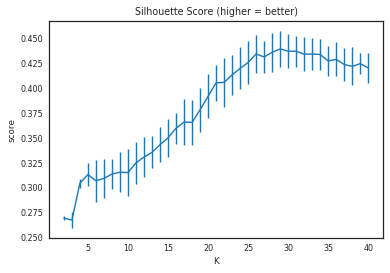

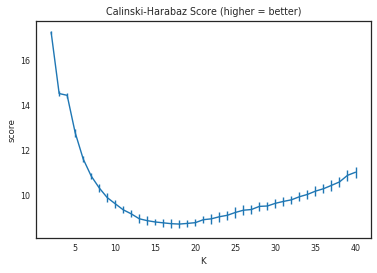

In [82]:
plt.figure()
plt.errorbar(Ks, mean_sil_scores, yerr=std_sil_scores)
plt.xlabel("K")
# plt.xticks(Ks)
plt.ylabel("score")
plt.title("Silhouette Score (higher = better)")

plt.figure()
plt.errorbar(Ks, mean_ch_scores, yerr=std_ch_scores)
plt.xlabel("K")
# plt.xticks(Ks)
plt.ylabel("score")
plt.title("Calinski-Harabaz Score (higher = better)")

In [67]:
print("Best K: ", Ks[np.argmax(mean_sil_scores)])

Best K:  29


In [68]:
best_K = 29
rpt = 1
_cluster = cached(os.path.join(results_dir, "kmeans"), "kmeans_K{}_rpt{}".format(best_K, rpt))(cluster_neurons)
perm, clusters, _, _, _ = _cluster(Cn_pca, best_K, seed=rpt)
divs = np.cumsum(np.bincount(clusters, minlength=best_K))

(83, 0)

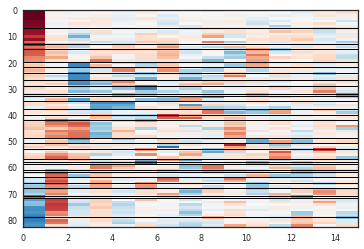

In [69]:
lim = abs(Cn_pca).max()
plt.imshow(Cn_pca[perm], aspect="auto", vmin=-lim, vmax=lim, cmap="RdBu_r", extent=(0, D, N, 0))
for div in divs:
    plt.plot([0, D], [div, div], '-k', lw=1)
plt.xlim(0, D)
plt.ylim(N, 0)

In [71]:
for k in range(best_K):
    print("Cluster ", k)
    for name in [name for kn, name in zip(clusters, neuron_names) if kn == k]:
        print(name)
        
    print("")

Cluster  0
AIBL
AIBR
AVAL
AVAR
RIML
RIMR
VA01

Cluster  1
AVEL
AVER
OLQDL
OLQDR
OLQVL
OLQVR

Cluster  2
SABVL
SABVR

Cluster  3
URYDL
URYDR
URYVL
URYVR
VA02

Cluster  4
URADL
URADR

Cluster  5
RIVL
RIVR

Cluster  6
AS01
DA01
SABD

Cluster  7
SMDVL
SMDVR

Cluster  8
AFDL
AFDR
SMBVL

Cluster  9
AWCR

Cluster  10
AWAL
RIFL

Cluster  11
ASKL
ASKR
AWBL

Cluster  12
ASGL
ASGR

Cluster  13
SMDDL
SMDDR

Cluster  14
AQR
AUAL
AUAR
IL2DR
IL2L
URXL
URXR

Cluster  15
RIGL
RIGR

Cluster  16
SAAVL
SAAVR

Cluster  17
ALA
AWCL
IL2DL
RMGL

Cluster  18
RMGR

Cluster  19
RIFR

Cluster  20
BAGL
BAGR

Cluster  21
VB03

Cluster  22
DB01
DB02

Cluster  23
AVFL
AVFR

Cluster  24
RIBL
RIBR

Cluster  25
AVBL
AVBR
RID

Cluster  26
RIS

Cluster  27
SIADL
SIBDL
SIBDR
SIBVL
SIBVR
VB01
VB02

Cluster  28
RMED
RMEL
RMER
RMEV



# Load per neuron location, type, functional type dat

In [72]:
import pandas as pd

neuron_locations_csv = pd.read_csv("~/Projects/zimmer/wormatlas_locations.csv")
neuron_locations = [np.array(neuron_locations_csv[neuron_locations_csv.name == name].location)[0] 
                    for name in neuron_names]
neuron_locations = np.array(neuron_locations)

In [73]:
neuron_celltypes_csv = pd.read_csv("~/Projects/zimmer/wormatlas_celltypes.csv")
neuron_celltypes = []
for name in neuron_names:
    neuron_celltypes.append(np.array(neuron_celltypes_csv[neuron_celltypes_csv.name == name].type)[0])
neuron_celltypes = np.array(neuron_celltypes)

In [74]:
neuron_functions_csv = pd.read_csv("~/Projects/zimmer/neuron_functions.csv")
functions = ['Fwd', 'Rev', 'FwdRev', 'DT', 'VT', 'Other', 'Quiescence', 'FwdQui', 'Sensory']
neuron_functions = []
for name in neuron_names:
    row = neuron_functions_csv[neuron_functions_csv.Name == name]
    assert len(row) == 1
    for f in functions:
        if np.array(row[f])[0] == 1:
            neuron_functions.append(f)
neuron_functions = np.array(neuron_functions)

# Make Figure 2: C matrix, Raw Correlation, Estimated Correlation

In [76]:
def _plot_corr(ax, corr, cmap):
    im = plt.imshow(corr[np.ix_(perm, perm)], cmap=cmap, vmin=-1, vmax=1, extent=(0, N, N, 0), aspect="auto")
    for div in divs:
        plt.plot([0, N], [div, div], '-k', lw=.5)
        plt.plot([div, div], [0, N], '-k', lw=.5)
    plt.xlim(0, N)
    plt.ylim(N, 0)
    return im

In [111]:
# Set colors for each function
functions = ['Fwd', 'Rev', 'FwdRev', 'DT', 'VT', 'Quiescence', 'FwdQui', 'Sensory', 'Other']
short_functions = ['Fwd', 'Rev', 'FR', 'DT', 'VT', 'Q', 'FQ', 'O$_2$', 'Unk']
func_colors = [zplt.default_colors[1], # fwd = red
          zplt.default_colors[0], # rev = blue
          "navy",                 # fwd/rev = navy
          zplt.default_colors[3], # dt = yellow
          zplt.default_colors[2], # vt = Green
          zplt.default_colors[4], # quiescence = purple
          'maroon',                 # fwdqui = maroon
          zplt.default_colors[7], # sensory = pink
          zplt.default_colors[8], # other = Grey
         ]

func_color_dict = dict(zip(functions, func_colors))

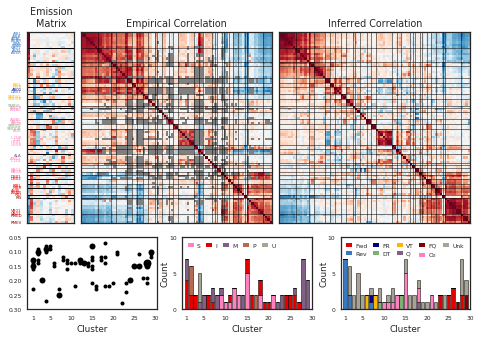

In [113]:
cmap = matplotlib.cm.RdBu_r
cmap.set_bad('gray',1.)

# Make plot
fig = plt.figure(figsize=(6.5, 4.6))
fig.patch.set_alpha(0)

# Plot C
lim = abs(Cn_pca).max()
ax = create_axis_at_location(fig, .25, 1.6, .65, 2.65)
plt.imshow(Cn_pca[perm], vmin=-lim, vmax=lim, cmap="RdBu_r", extent=(0, D, N, 0), aspect="auto")
for div in divs:
    plt.plot([0, D], [div, div], '-k', lw=1)
plt.xlim(0, D)
plt.xticks([])
plt.ylim(N, 0)

# Only put ticks at the locations of neurons with known functions
perm_names = neuron_names[perm]
perm_functions = neuron_functions[perm]
known_inds = np.where(perm_functions != 'Other')[0]
known_neurons = perm_names[known_inds]
known_functions = perm_functions[known_inds]
plt.yticks(known_inds + .5, known_neurons, fontsize=4)
assert len(ax.yaxis.get_ticklabels()) == len(known_neurons)
for tl, fn in zip(ax.yaxis.get_ticklabels(), known_functions):
    tl.set_color(func_color_dict[fn])
#plt.yticks(np.arange(N)+.5, neuron_names[perm], fontsize=3)
plt.title("Emission\nMatrix")

# Plot empirical correlation
ax = create_axis_at_location(fig, 1, 1.6, 2.65, 2.65)
im = _plot_corr(ax, emp_corr, cmap)
ax.set_xticks([])
ax.set_yticks([])
plt.title("Empirical Correlation")

# Plot model correlation
ax = create_axis_at_location(fig, 3.75, 1.6, 2.65, 2.65)
im = _plot_corr(ax, pca_corr, cmap)
ax.set_xticks([])
ax.set_yticks([])
plt.title("Inferred Correlation")

# Cluster locations
xticks = np.concatenate(([0], np.arange(4, best_K+1, step=5)))
xticklabels = xticks + 1
ax = create_axis_at_location(fig, .25, .4, 1.8, 1.)
location_bins = np.arange(neuron_locations.min(), neuron_locations.max()+.01, .01)
for k in range(best_K):
    locs_k, _ = np.histogram([l for l, c in zip(neuron_locations, clusters) if c == k], location_bins)
    
    for b, count in zip(location_bins, locs_k):
        if count > 0:
            plt.plot(k, b, 'ko', markersize=2 + 2 * count)
        
plt.xticks(xticks, xticklabels, fontsize=6)
plt.xlabel("Cluster")
plt.yticks(np.arange(0.05, 0.31, 0.05), fontsize=6)
plt.ylim(.30, .05)

# Cluster cell types
type_colors = [zplt.default_colors[7], zplt.default_colors[1], zplt.default_colors[4], zplt.default_colors[6], zplt.default_colors[8]]
ax = create_axis_at_location(fig, 2.4, .4, 1.8, 1.)
for k in range(best_K):
    offset = 0
    for i, t in enumerate(['S', 'I', 'M', 'P', 'U']):
        count = np.sum(neuron_celltypes[clusters == k] == t)
        plt.bar(k, count, width=.8, bottom=offset, color=type_colors[i], edgecolor='k', linewidth=.5)
        offset += count
        
# Make dummy legend
for i, t in enumerate(['S', 'I', 'M', 'P', 'U']):
    plt.bar(-1, 0, width=0, color=type_colors[i], label=t)
plt.legend(ncol=5, loc="upper left", handlelength=1, handletextpad=.5, columnspacing=1, fontsize=6)
        
plt.xticks(xticks, xticklabels, fontsize=6)
plt.xlabel("Cluster")
plt.xlim(-1, best_K)
plt.yticks(np.arange(0, 21, 5), fontsize=6)
plt.ylabel("Count", labelpad=-1)
plt.ylim(0, 10)

# Cluster functional types
ax = create_axis_at_location(fig, 4.6, .4, 1.8, 1.)
for k in range(best_K):
    offset = 0
    for i, t in enumerate(functions):
        count = np.sum(neuron_functions[clusters == k] == t)
        plt.bar(k, count, width=.8, bottom=offset, color=func_colors[i], edgecolor='k', linewidth=.5)
        offset += count

# Make dummy legend
for i, t in enumerate(short_functions):
    plt.bar(-1, 0, width=0, color=func_colors[i], label=t)
plt.legend(ncol=5, loc="upper left", handlelength=1, handletextpad=.5, columnspacing=1, fontsize=6)
        
plt.xticks(xticks, xticklabels, fontsize=6)
plt.xlabel("Cluster")
plt.xlim(-1, best_K)
plt.yticks(np.arange(0, 21, 5), fontsize=6)
plt.ylabel("Count", labelpad=-1)
plt.ylim(0, 10)


figname = "clustering"
plt.savefig(os.path.join(figures_dir, figname + ".png"), dpi=300)
plt.savefig(os.path.join(figures_dir, figname + ".pdf"))